#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

https://towardsdatascience.com/5-types-of-plots-that-will-help-you-with-time-series-analysis-b63747818705

In [60]:
import numpy as np

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

palette = sns.color_palette("husl")

## Подготовка

In [46]:
df = pd.read_csv('../datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
print("Is the index sorted:", df.index.is_monotonic)
df


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Is the index sorted: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


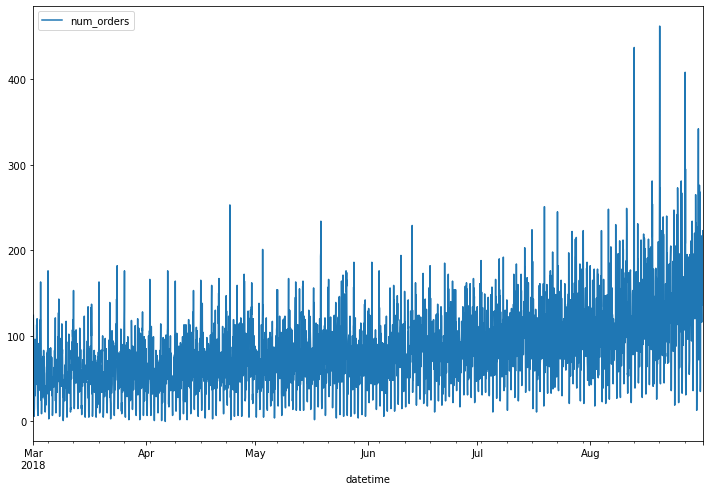

In [48]:
df = df.resample('1H').sum()
df.plot(figsize=(12,8))
df


## Анализ

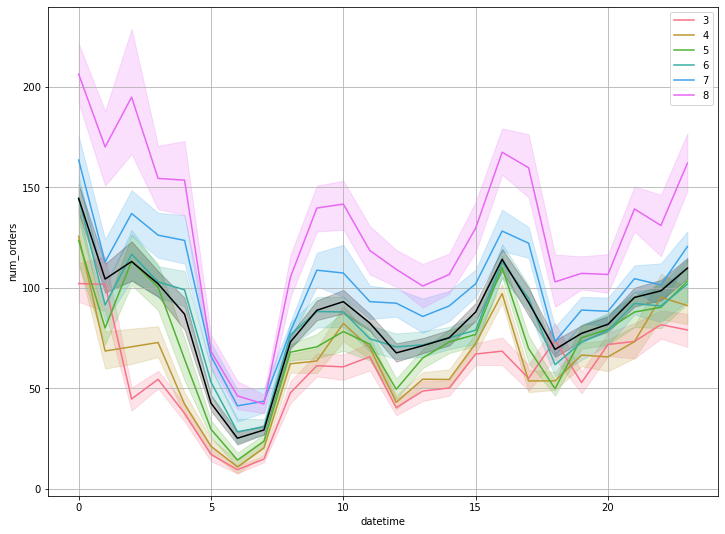

In [53]:
plt.figure(figsize=(12, 9))
ax1 = sns.lineplot(data=df, x=df.index.hour, y='num_orders',
             hue=df.index.month, palette=palette)
ax1.legend(title='all')
ax2 = sns.lineplot(data=df, x=df.index.hour, y='num_orders', color='black')
ax2.legend()
plt.grid()

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

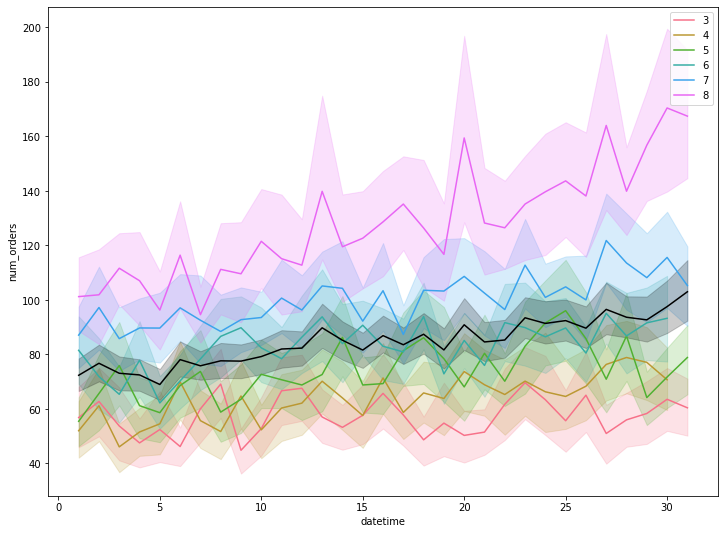

In [38]:
plt.figure(figsize=(12, 9))
sns.lineplot(data=df, x=df.index.day, y='num_orders',
             hue=df.index.month, palette=palette)
sns.lineplot(data=df, x=df.index.day, y='num_orders', color='black')

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

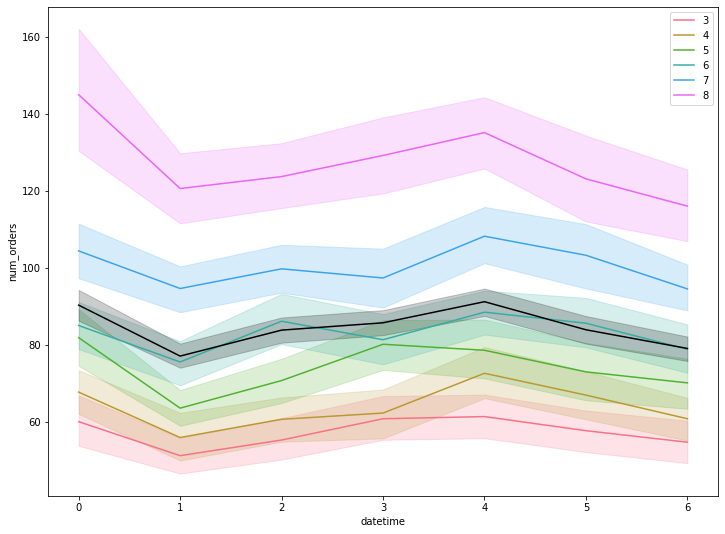

In [39]:
plt.figure(figsize=(12, 9))
sns.lineplot(data=df, x=df.index.weekday, y='num_orders',
             hue=df.index.month, palette=palette)
sns.lineplot(data=df, x=df.index.weekday, y='num_orders', color='black')


In [65]:
len(df.index.weekday.unique())

7

In [76]:
df.index.weekday


Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='datetime', length=4416)

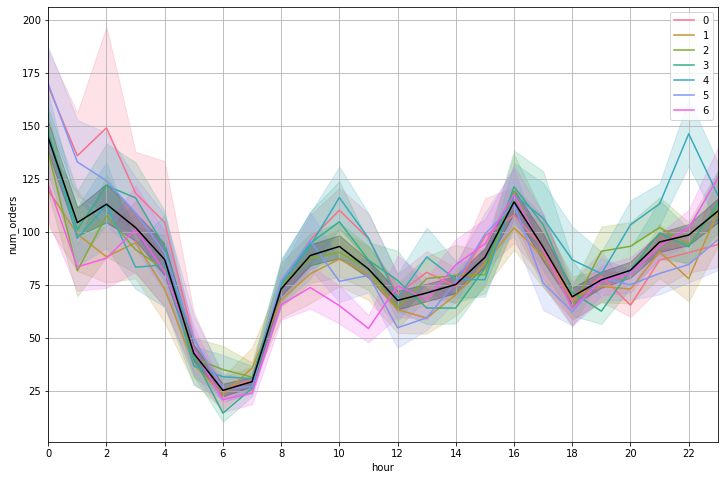

In [78]:
def plot_average(df, x, y, hue=None, xlabel=None, x_step=2):
    plt.figure(figsize=(12, 8))
    if hue is not None:
        palette = sns.color_palette("husl", len(hue.unique()))
        sns.lineplot(data=df, x=x, y=y, hue=hue, palette=palette)
    sns.lineplot(data=df, x=x, y=y, color='black')
    plt.xlim((x.min(), x.max()))
    plt.xticks(np.arange(x.min(), x.max()+1, x_step))
    if xlabel: plt.xlabel(xlabel)
    plt.grid()
    plt.show()


plot_average(df, x=df.index.hour, y='num_orders',
             hue=df.index.weekday, xlabel='hour')


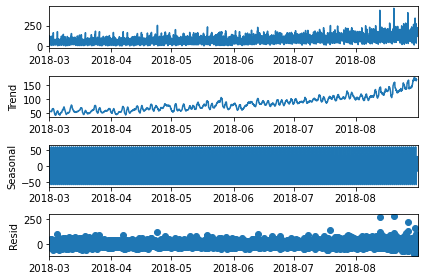

<Figure size 864x648 with 0 Axes>

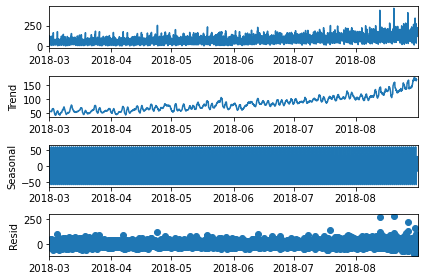

In [18]:
plt.figure(figsize=(12, 9))
decomposition = seasonal_decompose(df)
decomposition.plot()

## Обучение

## Тестирование

In [56]:

train, test = train_test_split(df, shuffle=False, test_size=0.1)

y_pred_previous = test.shift()
y_pred_previous.iloc[0] = train.iloc[-1]

print("RMSE:", mean_squared_error(y_pred_previous, test, squared=False))


RMSE: 58.856486242815066


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48